Import packages and libraries

In [1]:
import numpy as np
import math
import pandas as pd
from sklearn.cluster import KMeans
import os
from sklearn.metrics import adjusted_rand_score, silhouette_score, adjusted_mutual_info_score, normalized_mutual_info_score, confusion_matrix, calinski_harabasz_score, davies_bouldin_score
from sklearn import metrics
from scipy.special import comb
from scipy.sparse.linalg import eigsh, eigs
from scipy.sparse import csr_matrix, diags, coo_matrix
import scipy.linalg as LA
from scipy.spatial import distance
from matplotlib import pyplot as plt
from scipy.sparse.csgraph import minimum_spanning_tree
import warnings
warnings.filterwarnings("ignore")

# Validity Indices

In [2]:
def rand_index_score(clusters, classes):
    tp_plus_fp = comb(np.bincount(clusters), 2).sum()
    tp_plus_fn = comb(np.bincount(classes), 2).sum()
    A = np.c_[(clusters, classes)]
    tp = sum(comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum()
             for i in set(clusters))
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = comb(len(A), 2) - tp - fp - fn
    return (tp + tn) / (tp + fp + fn + tn)

In [3]:
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

# Proposed method

Partitioning step

In [4]:
def bi_means_devide(X, X_indices, k, P, centroids, farthest_points1, farthest_points2):
  N = len(X_indices)
  X_partition = X[X_indices]

  if N > k: # base condition
    X_indices_arr = np.array(X_indices)
    center = X_partition.mean(axis=0) # centroid of the partition

    distances = distance.cdist([center], X_partition)
    c_index = distances[0].argmin() #closest point from centeroid

    distances = distance.cdist([X_partition[c_index]], X_partition)
    p_index = distances[0].argmax() # farthest point from c

    distances = distance.cdist([X_partition[p_index]], X_partition)
    q_index = distances[0].argmax() # farthest point from p

    # spliting of a partition into two sub-partitions
    distances = distance.cdist(X_partition, [X_partition[p_index], X_partition[q_index]])

    min_i = distances.argmin(axis = 1)
    
    p_min_Is = np.where(min_i == 0)[0]
    q_min_Is = np.where(min_i == 1)[0]
    
    # recursively calling bi_means_devide for the sub-partitions
    bi_means_devide(X, X_indices_arr[p_min_Is], k, P, centroids, farthest_points1, farthest_points2)
    bi_means_devide(X, X_indices_arr[q_min_Is], k, P, centroids, farthest_points1, farthest_points2)
  else:
    P.append(X_indices.tolist()) # adding the partition

    # finding of representative points
    center = X_partition.mean(axis=0)

    distances = distance.cdist([center], X_partition)
    p_index = distances[0].argmax() # farthest point from c

    distances = distance.cdist([X_partition[p_index]], X_partition)
    q_index = distances[0].argmax() # farthest point from p

    distances = distance.cdist(X_partition, [X_partition[p_index], X_partition[q_index]])
    min_i = distances.argmin(axis = 1)

    p_min_Is = np.where(min_i == 0)[0]
    q_min_Is = np.where(min_i == 1)[0]

    X_p = X_partition[p_min_Is]
    X_q = X_partition[q_min_Is]
    
    centroids.append(center) # first representative point

    if len(X_p) == 0:
      farthest_points1.append(center)
    else:
      farthest_points1.append(X_p.mean(axis=0)) # second representative point
    if len(X_q) == 0:
      farthest_points2.append(center)
    else:
      farthest_points2.append(X_q.mean(axis=0)) # third representative point

Similarity graph computation

In [5]:
def bimeans_fast_mst_10(X, N, k, num_features, num_rounds_neighbors=2, num_rounds=2):
    # partitioning and representative points
    P = []
    centroids = []
    farthest_points1 = []
    farthest_points2 = []
    vertices = np.arange(N, dtype=int)
    bi_means_devide(X, vertices, k, P, centroids, farthest_points1, farthest_points2)
    n = len(centroids)
    
    farthest_points1_arr = np.array(farthest_points1)
    farthest_points2_arr = np.array(farthest_points2)
    centroids_arr = np.array(centroids)
    
    R = np.hstack((centroids_arr, farthest_points1_arr, farthest_points2_arr)) # representative points od each partition
    R = R.reshape((R.shape[0], 3, R.shape[1] // 3))
  
    # computing neighboring partitions
    cen_distances = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            dist_arr = distance.cdist(R[i], R[j])
            d = dist_arr.min()
            d_index = dist_arr.argmin()
            cen_distances[i][j] = d
            cen_distances[j][i] = d

    _MST_CEN_1 = coo_matrix(minimum_spanning_tree(cen_distances))
    cen_distances[_MST_CEN_1.row, _MST_CEN_1.col] = 0
    cen_distances[_MST_CEN_1.col, _MST_CEN_1.row] = 0
    Edges_single =  _MST_CEN_1.data
    MST1 = np.hstack(( _MST_CEN_1.row.reshape(n - 1, 1), _MST_CEN_1.col.reshape(n - 1, 1) ))
    
    try:
        _MST_CEN_2 = coo_matrix(minimum_spanning_tree(cen_distances))
        Edges_single =  _MST_CEN_2.data
        MST2 = np.hstack(( _MST_CEN_2.row.reshape(n - 1, 1), _MST_CEN_2.col.reshape(n - 1, 1) ))
        
        NP = np.concatenate((MST1, MST2)) # neighboring partitions
    except:
        NP = MST1
    
    G_L = csr_matrix((N, N))

    # computing IPM for each neighboring partitions
    for subset_pairs in NP:
        i, j = subset_pairs[0], subset_pairs[1]
        subset_i, subset_j = P[i], P[j]

        subset = np.array(subset_i + subset_j)
        _n = len(subset)
        X_s = X[subset]

        D = distance.cdist(X_s, X_s)

        MST1 = coo_matrix(minimum_spanning_tree(D))
        MST_1_weights = MST1.data
        # print(subset, MST1.row)
        # print(subset[MST1.row])
        D[MST1.row, MST1.col] = 0
        D[MST1.col, MST1.row] = 0
        MST1 = np.hstack(( subset[MST1.row].reshape(_n - 1, 1), subset[MST1.col].reshape(_n - 1, 1) ))

        try:
            MST2 = coo_matrix(minimum_spanning_tree(D))
            MST_2_weights = MST2.data
            MST2 = np.hstack(( subset[MST2.row].reshape(_n - 1, 1), subset[MST2.col].reshape(_n - 1, 1) ))
            IPM = np.concatenate((MST1, MST2)) # Inter-partition MST
            IPM_weights = np.concatenate((MST_1_weights, MST_2_weights))
        except:
            # print(_i, "graph disconnected")
            IPM = MST1
            IPM_weights = MST_1_weights
        
        G_L[IPM[:, 0], IPM[:, 1]] = IPM_weights
        G_L[IPM[:, 1], IPM[:, 0]] = IPM_weights

        
    # 2-rounds MST
    MST1 = coo_matrix(minimum_spanning_tree(G_L))
    MST1_weights = MST1.data
    G_L[MST1.row, MST1.col] = 0
    G_L[MST1.col, MST1.row] = 0
    G_L.eliminate_zeros()
    MST1 = np.hstack(( MST1.row.reshape(N - 1, 1), MST1.col.reshape(N - 1, 1) ))

    try:
        MST2 = coo_matrix(minimum_spanning_tree(G_L))
        MST2_weights = MST2.data
        MST2 = np.hstack(( MST2.row.reshape(N - 1, 1), MST2.col.reshape(N - 1, 1) ))
        MST_2 = np.concatenate((MST1, MST2)) # neighboring partitions
        MST_2_weights = np.concatenate((MST1_weights, MST2_weights))
    except:
        # print("LNG graph disconnected")
        MST_2 = MST1
        MST_2_weights = MST1_weights
    
    # computing adjacency matrix
    A = csr_matrix((N, N))
    A[MST_2[:, 0], MST_2[:, 1]] = MST_2_weights
    A[MST_2[:, 1], MST_2[:, 0]] = MST_2_weights

    return G_L, MST_2, A

Finding smallest eigenvectors

In [6]:
def get_k_smallest_eigenvectors(A, N, K, flag = True):
    A1 = A.sum(axis=1)
    A1 = A1.reshape(N)
    D = diags(np.array(A1)[0]) # degree matrix
    L = D - A #laplacian matrix
    if flag:
        vals, vecs = eigsh(L, k=K, which='SM') # K-smallest eigenvectors using lancsoz
        vecs = vecs[:,np.argsort(vals.real)]
    else: #ignores smallest eigenvector
        vals, vecs = eigsh(L, k=K+1, which='SM')
        vecs = vecs[:,np.argsort(vals.real)[1:]]
    return vecs.real.astype('float32')

Spectral clustering

In [7]:
def mySC(X, K):
    N, num_features = X.shape
    k = math.ceil(N ** 0.5)
    G_L, MST_2, A = bimeans_fast_mst_10(X, N, math.ceil(k / (8 ** 0.5)), num_features)
    
    k_vecs = get_k_smallest_eigenvectors(A, N, K)
    
    max_ari, max_ri, max_pu, max_ami = -1, 0, 0, 0
    max_labels = None
    for iter in range(10):
        kmeans = KMeans(n_clusters=K, n_init=1, init='random')
        kmeans.fit(k_vecs)
        labels = kmeans.labels_
        ari, ri, pu, ami = adjusted_rand_score(labels, lab), rand_index_score(labels, lab), purity_score(lab, labels), adjusted_mutual_info_score(labels, lab)
        if ari > max_ari:
            max_ari, max_ri, max_pu, max_ami = ari, ri, pu, ami
            max_labels = labels
    
    return max_ari, max_ri, max_pu, max_ami, max_labels

# Test

Load dataset

In [8]:
file_path, sep = "flame_k=2.txt", "\t"
df = pd.read_csv(file_path, sep=sep, header=None)
df, lab = df.iloc[:, :-1], df.iloc[:, -1].astype('int')
K = len(set(lab)) # number of clusters
X = np.array(df, dtype='float32')
is_plot = True # to visualize the results of 2D synthetic datasets

Run proposed algorithm

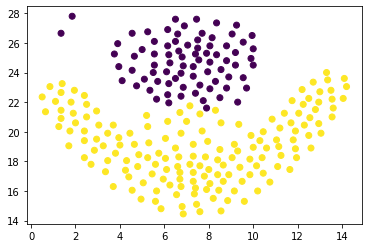

RI: 0.9352859135285914
ARI: 0.8695133875459655
AMI: 0.8101141172291583
Purity: 0.9666666666666667


In [9]:
ari, ri, pu, ami, labels = mySC(X, K)

if is_plot:
    plt.scatter(X[:, 0], X[:, 1], c = labels)
    plt.show()
print("RI:", ri)
print("ARI:", ari)
print("AMI:", ami)
print("Purity:", pu)